In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Na22/run3614.dst"

In [2]:
from __future__ import print_function, division

import os
import sys
import time
import glob

import tables            as tb
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions  as coref
import invisible_cities.core.fit_functions   as fitf
import invisible_cities.reco.peak_functions  as pf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.reco.tbl_functions   as tbf
import invisible_cities.reco.dst_functions   as dstf

from invisible_cities.reco.params import Correction

pi = np.pi

print("Running on ", time.asctime())

Running on  Fri Apr 14 17:54:20 2017


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8

In [4]:
def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, y.size)
    y_ = np.tile  (y, x.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

In [5]:
def load_z_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Zcorrections")
    return Correction(dst.z.values, dst.factor.values, dst.uncertainty.values)


def load_xy_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "XYcorrections")
    x    = np.unique (dst.x          .values)
    y    = np.unique (dst.y          .values)
    f    = np.reshape(dst.factor     .values, (len(x), len(y)))
    u    = np.reshape(dst.uncertainty.values, (len(x), len(y)))
    return Correction((x,y), f, u)

def load_t_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Tcorrections")
    return Correction(dst.t.values, dst.factor.values, dst.uncertainty.values)



In [20]:
corrfilename = "/Users/Gonzalo/github/NEXTdata/Kr2016/data/run3389.corr"
zcorr  = load_z_corrections (corrfilename)
xycorr = load_xy_corrections(corrfilename)
tcorr  = load_t_corrections (corrfilename)

In [21]:
dst = dstf.load_dst(inputfilename, "DST", "Events")
dst.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105


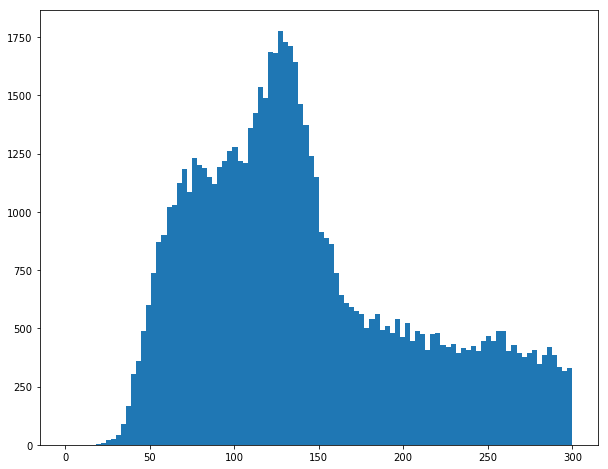

In [57]:
plt.hist(dst.S1e[dst.nS2 ==2], 100, (0, 300));

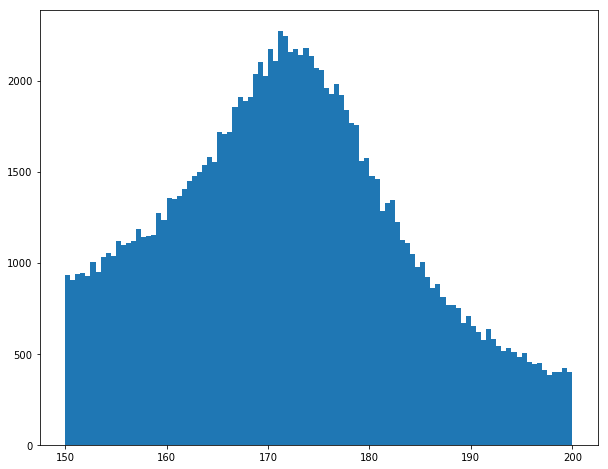

In [65]:
plt.hist(dst.Z, 100, (150, 200));

9.74472367416


/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 / (len(x) - len(vals)))


5.98547818139
4.92376865802


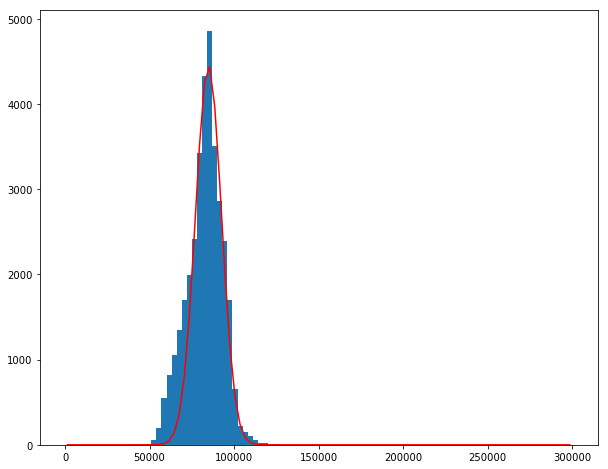

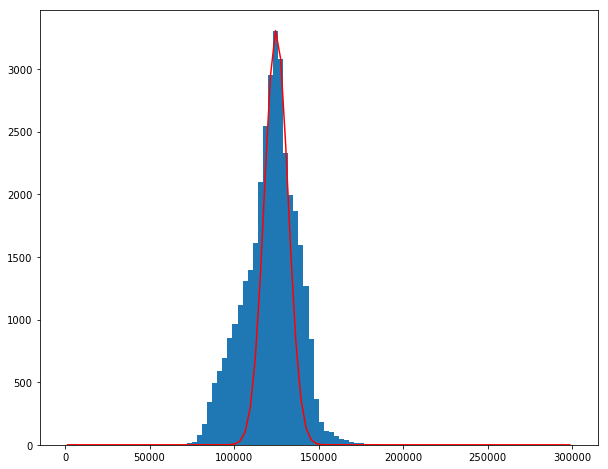

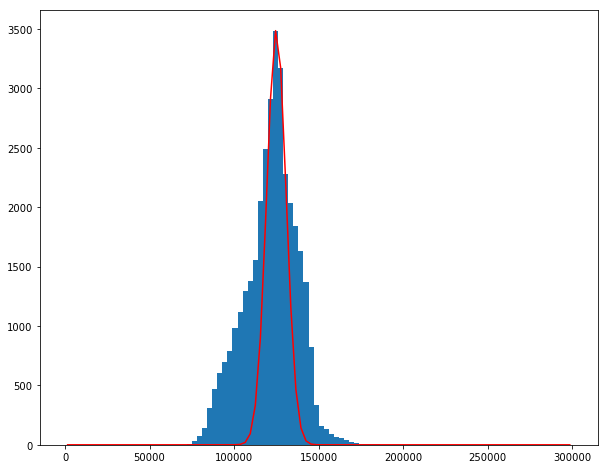

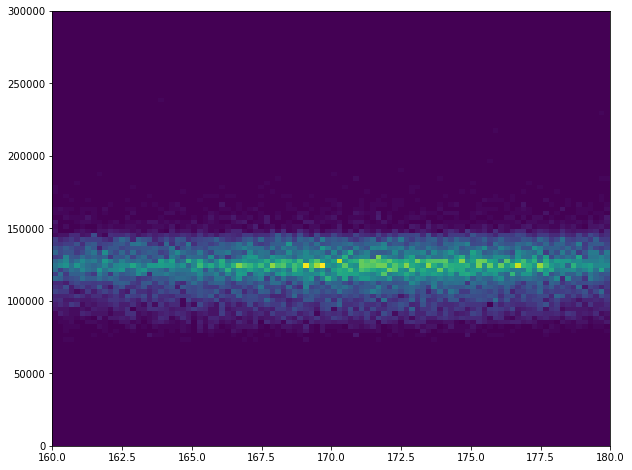

In [150]:
data = dst[dst.S2e>50e3] 
data = data[fitf.in_range(data.S1e, 100, 150)]
data = data[fitf.in_range(data.Z  , 160, 180)]
y, x, _ = plt.hist(data.S2e, 100, (0, 3e5)); x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e6, 1e5, 1e3), fit_range=(75e3, 95e3))
plt.plot(x, f.fn(x), "r-")
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)

plt.figure()
y, x, _ = plt.hist(data.S2e * zcorr(170)[0], 100, (0, 3e5)); x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e6, 130e3, 1e3), fit_range=(120e3, 130e3))
plt.plot(x, f.fn(x), "r-")
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)

plt.figure()
y, x, _ = plt.hist(data.S2e * zcorr(data.Z)[0], 100, (0, 3e5)); x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e6, 130e3, 1e3), fit_range=(120e3, 130e3))
plt.plot(x, f.fn(x), "r-")
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)


plt.figure()
plt.hist2d(data.Z, data.S2e * zcorr(data.Z)[0], 100, ((160, 180),(0, 3e5)));

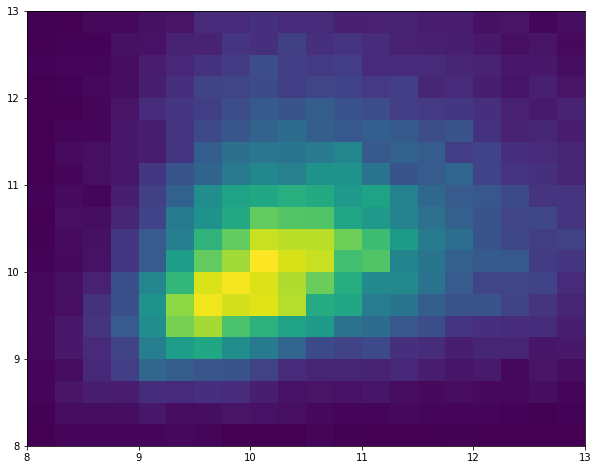

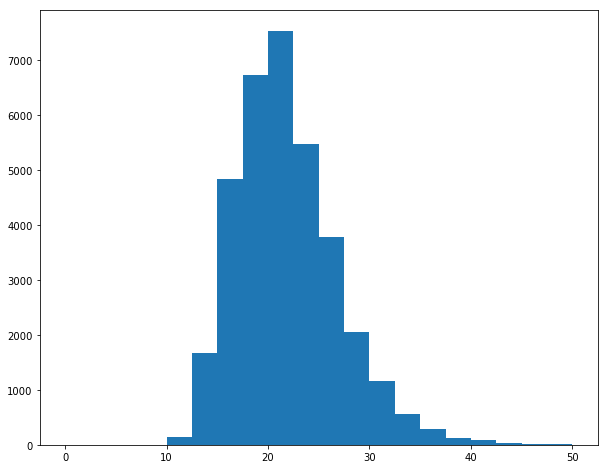

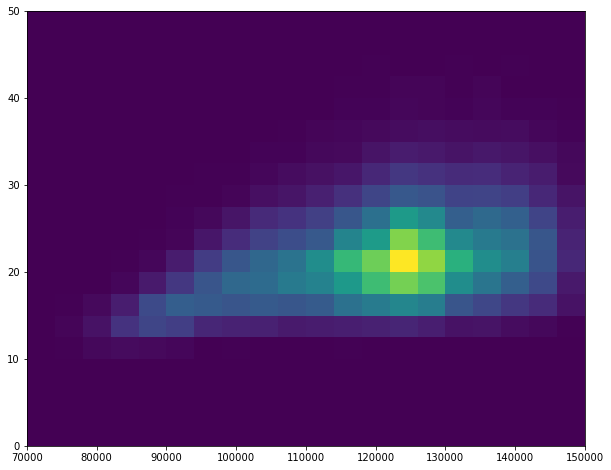

In [179]:
data = dst[dst.S2e>50e3]
data = data[fitf.in_range(data.S1e, 100, 150)]
data = data[fitf.in_range(data.Z  , 160, 180)]
plt.hist2d(data.Xrms, data.Yrms, 20, range=((8, 13),(8,13)))

plt.figure()
plt.hist(data.S2w, 20, range=(0,50))
plt.figure()
plt.hist2d(data.S2e * zcorr(data.Z)[0], data.S2w, 20, range=((70e3, 150e3),(0,50)));

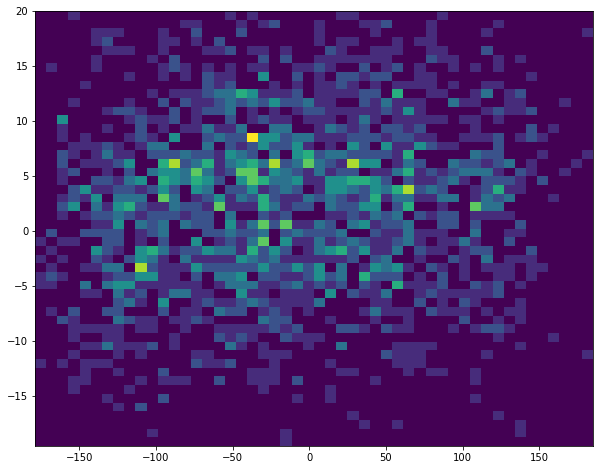

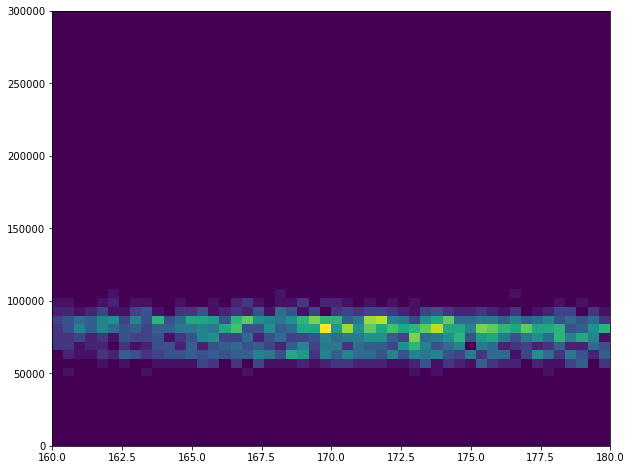

In [190]:
data = dst[dst.S2e>50e3]
data = data[fitf.in_range(data.S1e, 100, 150)]
data = data[fitf.in_range(data.Z  , 160, 180)]
data = data[fitf.in_range(data.S2w,  15,  25)]
data = data[fitf.in_range(data.Xrms, 9, 10)]
data = data[fitf.in_range(data.Yrms, 9, 10)]
fid  = data[fitf.in_range(data.Y.values, -20, 20)]
plt.hist2d(fid.X.values, fid.Y.values, 50);
plt.figure()
plt.hist2d(fid.Z.values, fid.S2e.values, 50, range=((160, 180),(0, 300e3)));

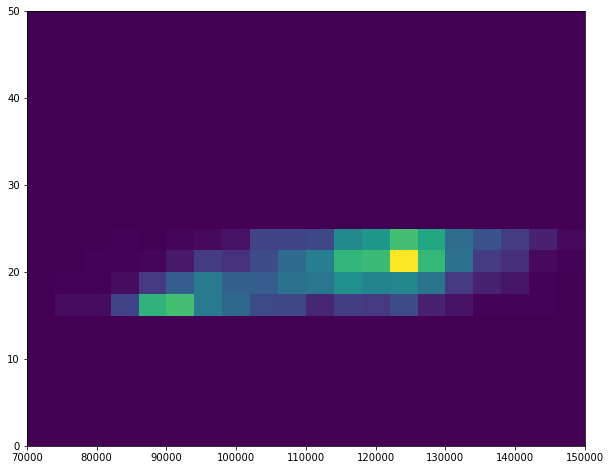

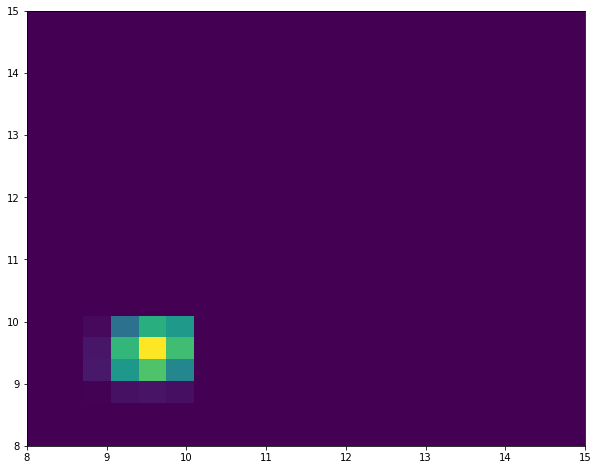

In [191]:
plt.figure()
plt.hist2d(fid.S2e * zcorr(fid.Z)[0], fid.S2w, 20, range=((70e3, 150e3),(0,50)));
plt.figure()
plt.hist2d(fid.Xrms, fid.Yrms, 20, range=((8, 15),(8,15)));

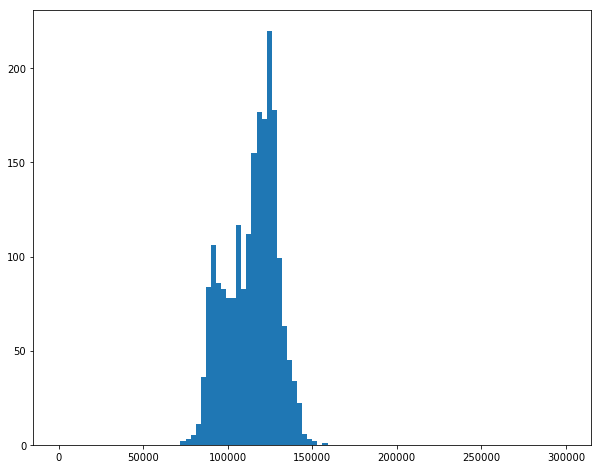

In [192]:
plt.hist(fid.S2e * zcorr(fid.Z.values)[0], 100, (0, 300e3));

117336.446419


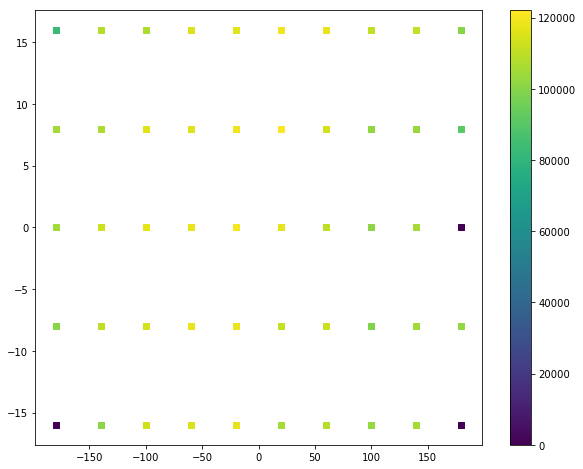

In [193]:
E = fid.S2e.values * zcorr(fid.Z.values)[0]
pf, _, cb = profile_and_scatter(fid.X.values, fid.Y.values, E, (10, 5), xrange=(-200, 200), yrange=(-20, 20))

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return (eref/ e, 0)
    return xycorr
xycorr = get_xycorr(*pf[:-1])

[ 1984827.59960184   122277.08274669     6665.69819038]
5.84101000234


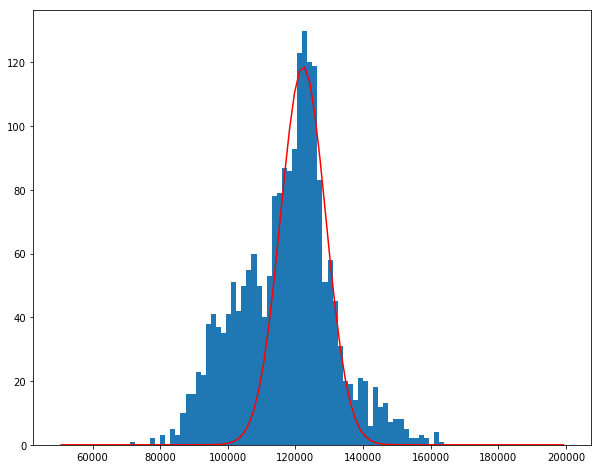

In [204]:
y, x, _ = plt.hist(fid.S2e * zcorr(fid.Z.values)[0] * xycorr(fid.X.values, fid.Y.values)[0], 100, (50e3, 200e3))
x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e7, 125e3, 3e3), fit_range=(115e3, 140e3))
plt.plot(x, f.fn(x), "r-")
print(f.values)
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)

115143.662165
97929.1700338


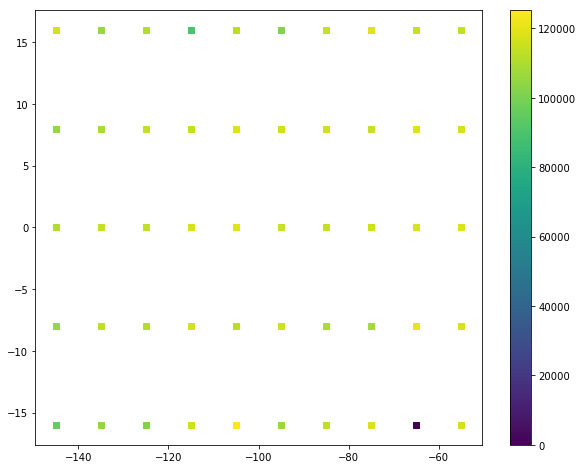

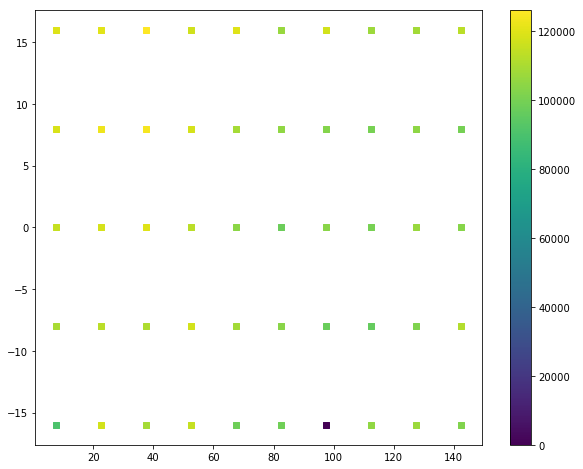

In [195]:
negX = fid[fitf.in_range(fid.X.values, -150, -50)]
posX = fid[fitf.in_range(fid.X.values,    0, 150)]

E = negX.S2e.values * zcorr(negX.Z.values)[0]
pf, _, cb = profile_and_scatter(negX.X.values, negX.Y.values, E, (10, 5), xrange=(-150, -50), yrange=(-20, 20))
negxycorr = get_xycorr(*pf[:-1])

E = posX.S2e.values * zcorr(posX.Z.values)[0]
pf, _, cb = profile_and_scatter(posX.X.values, posX.Y.values, E, (10, 5), xrange=(   0, 150), yrange=(-20, 20))

posxycorr = get_xycorr(*pf[:-1])

[ 1338388.36708123   123298.89607246     5437.31884189]
4.72512155558
[ 996138.95487034  130294.4494085     8701.27866798]
7.15557496096


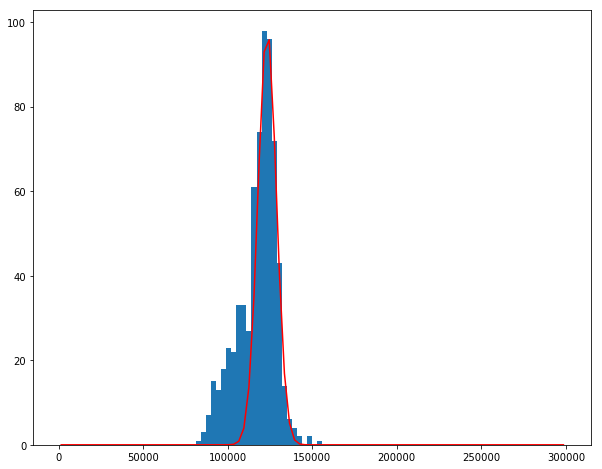

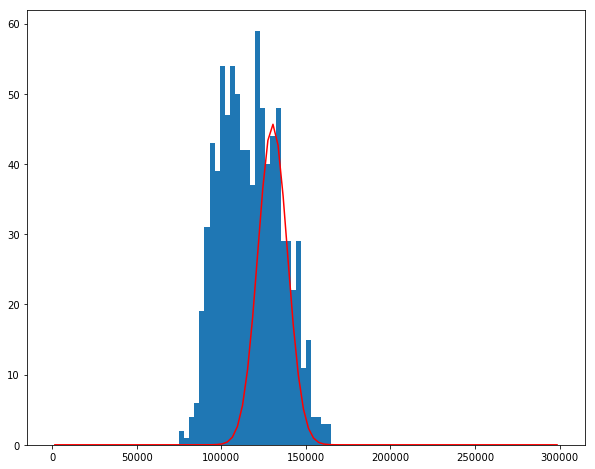

In [196]:
y, x, _ = plt.hist(negX.S2e * zcorr(negX.Z.values)[0] * xycorr(negX.X.values, negX.Y.values)[0], 100, (0, 300e3))
x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e7, 125e3, 3e3), fit_range=(122e3, 140e3))
plt.plot(x, f.fn(x), "r-")
print(f.values)
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)

plt.figure()
y, x, _ = plt.hist(posX.S2e * zcorr(posX.Z.values)[0] * xycorr(posX.X.values, posX.Y.values)[0], 100, (0, 300e3))
x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e7, 125e3, 3e3), fit_range=(130e3, 140e3))
plt.plot(x, f.fn(x), "r-")
print(f.values)
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)


[ 923436.87389997  123719.91622724    4925.38164757]
4.26567382108


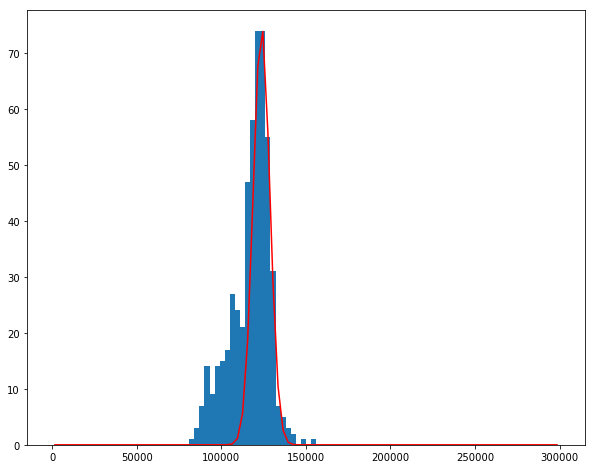

In [197]:
negX2 = negX[negX.R<120]
y, x, _ = plt.hist(negX2.S2e * zcorr(negX2.Z.values)[0] * xycorr(negX2.X.values, negX2.Y.values)[0], 100, (0, 300e3))
x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e7, 125e3, 3e3), fit_range=(122e3, 140e3))
plt.plot(x, f.fn(x), "r-")
print(f.values)
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)

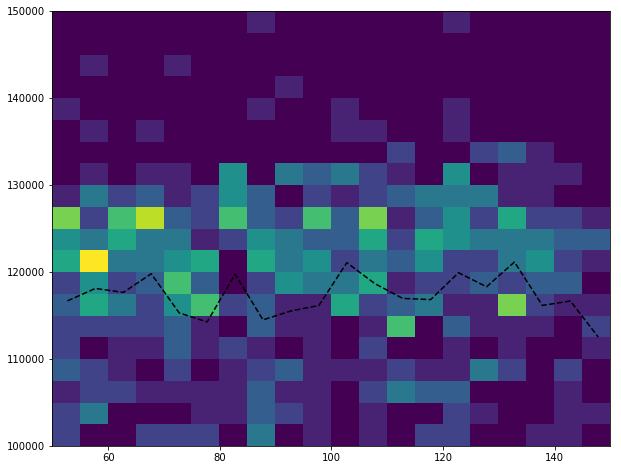

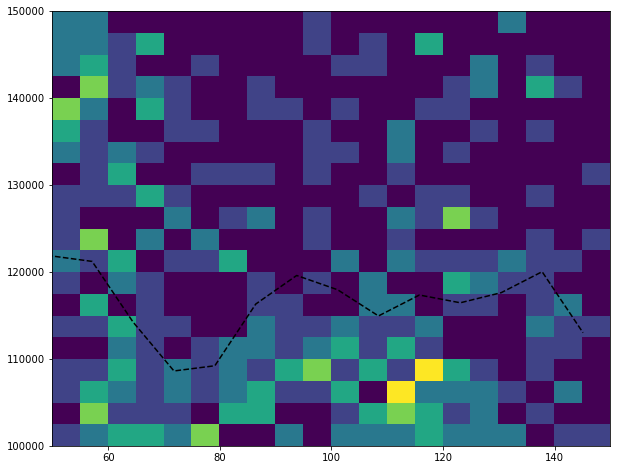

In [198]:
E = negX.S2e * zcorr(negX.Z.values)[0] * xycorr(negX.X.values, negX.Y.values)[0]
plt.hist2d(negX.R, E, 20, range=((50, 150), (100e3, 150e3)))
x, y, _ = fitf.profileX(negX.R, E, 20)
plt.plot(x, y, "k--")

plt.figure()
E = posX.S2e * zcorr(posX.Z.values)[0] * xycorr(posX.X.values, posX.Y.values)[0]
plt.hist2d(posX.R, E, 20, range=((50, 150), (100e3, 150e3)))
x, y, _ = fitf.profileX(posX.R, E, 20)
plt.plot(x, y, "k--")


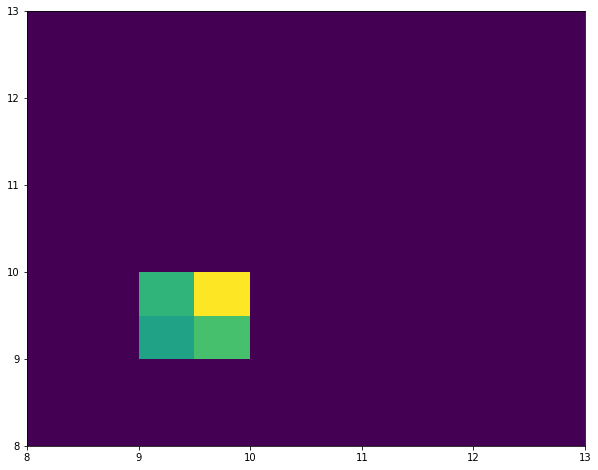

In [173]:
plt.hist2d(negX.Xrms, negX.Yrms, 10, range=((8, 13),(8,13)));

In [140]:
fidrms = negX[(fitf.in_range(negX.Xrms,9.5, 10.5)) & (fitf.in_range(negX.Yrms,9.5, 10.5))]

[ 1963469.9954768    129856.76592822     4629.54857594]
3.81998304931


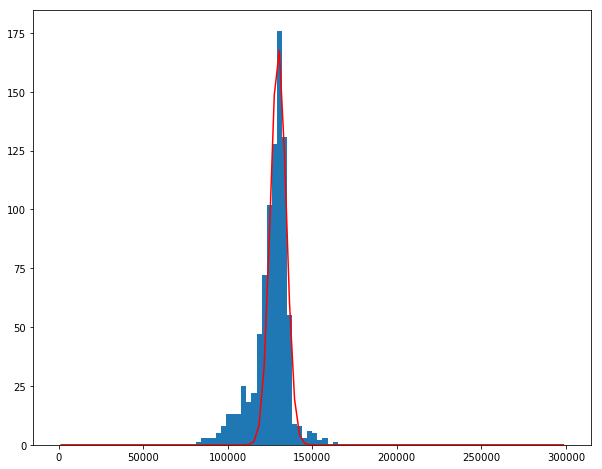

In [144]:
negX2 = fidrms[fidrms.R<120]
y, x, _ = plt.hist(negX2.S2e * zcorr(negX2.Z.values)[0] * xycorr(negX2.X.values, negX2.Y.values)[0], 100, (0, 300e3))
x = x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e7, 125e3, 3e3), fit_range=(122e3, 140e3))
plt.plot(x, f.fn(x), "r-")
print(f.values)
print(235*f.values[2]/f.values[1] * (511/2458)**0.5)

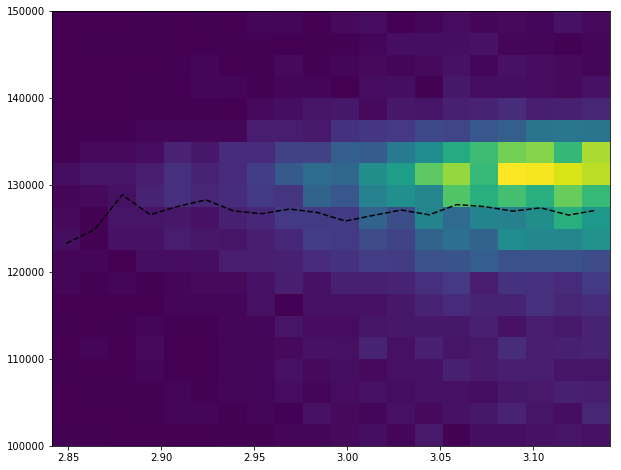

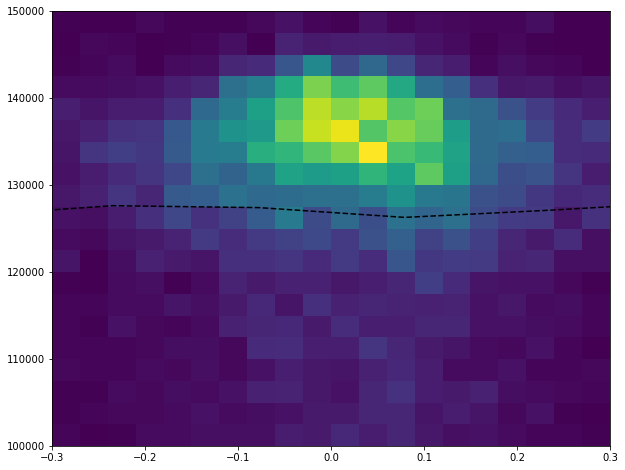

In [133]:
E = negX.S2e * zcorr(negX.Z.values)[0] * xycorr(negX.X.values, negX.Y.values)[0]
plt.hist2d(abs(negX.Phi), E, 20, range=((pi-0.3, pi), (100e3, 150e3)))
x, y, _ = fitf.profileX(negX.Phi, E, 20, xrange=(pi-0.3, pi))
plt.plot(x, y, "k--")

plt.figure()
E = posX.S2e * zcorr(posX.Z.values)[0] * xycorr(posX.X.values, posX.Y.values)[0]
plt.hist2d(posX.Phi, E, 20, range=((-0.3, 0.3), (100e3, 150e3)))
x, y, _ = fitf.profileX(posX.Phi, E, 20)
plt.plot(x, y, "k--")


[ 8769.66610583  -336.3684026 ]


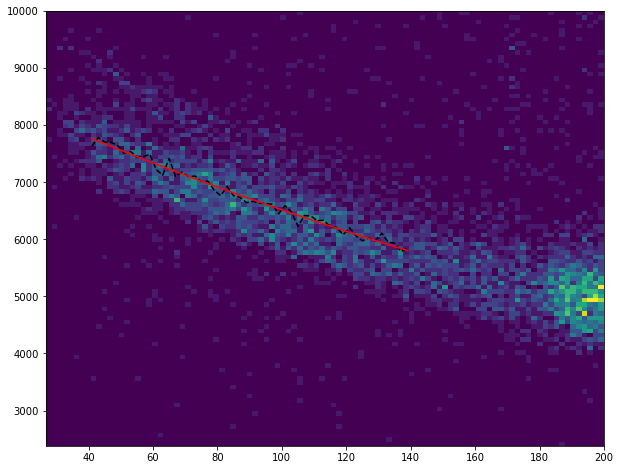

In [134]:
data = dst[(dst.S2e<1e4) & (dst.Z<200) & (dst.R<100)]
plt.hist2d(data.Z.values, data.S2e, 100)
x, y, _ = fitf.profileX(data.Z.values, data.S2e.values, 50, (40, 140))
plt.plot(x, y, "k--")
f = fitf.fit(fitf.expo, data.Z.values, data.S2e.values, (8e3, -300), fit_range=(40, 140))
plt.plot(x, f.fn(x), "r-")
print(f.values)

zfun  = f.fn
zcorr = lambda z: [zfun(40)/zfun(z), 0]

In [123]:
(x, y), e = xycorr.xs.T, xycorr.fs.flatten()
x = np.repeat(x, x.size)
y = np.tile  (y, y.size)

sel = (x**2 + y**2) < 180**2
x = x[sel]
y = y[sel]
e = e[sel]

plt.hist2d(x, y, (100,100), range=((-215,215), (-215,215)), weights=e)
plt.colorbar()

AttributeError: 'function' object has no attribute 'xs'

In [ ]:
data = dst[fitf.in_range(dst.S2e, 0, 1e4)]

bins = np.linspace(2e3, 15e3, 100)
E = np.array(data.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(data.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(data.X.values, data.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="m"); x2 = x2[:-1] + np.diff(x2) * 0.5


m0, m1, m2 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e6, m0, 300), fit_range=(m0 - 2000, m0 + 2000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e6, m1, 300), fit_range=(m1 - 2000, m1 + 2000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e6, m2, 300), fit_range=(m2 - 2000, m2 + 2000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x2), "m-")

r0, r1, r2 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1]
plt.text(10e3, 400, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (29.6/2458)**0.5), color="b")
plt.text(10e3, 600, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (29.6/2458)**0.5), color="g")
plt.text(10e3, 800, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (29.6/2458)**0.5), color="m")

plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)

In [ ]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]
data = data[fitf.in_range(data.Y,    -30,    30)]
data = data[fitf.in_range(data.Z,    150,   200)]

bins = np.linspace(50e3, 30e4, 100)
E = np.array(data.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(data.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

#E *= xycorr(data.X.values, data.Y.values)[0]
#y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="m"); x2 = x2[:-1] + np.diff(x2) * 0.5


m0, m1, m2 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e8, m0, 3000), fit_range=(m0 - 20000, m0 + 20000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e8, m1, 3000), fit_range=(m1 - 20000, m1 + 20000))
#f2 = fitf.fit(fitf.gauss, x2, y2, (1e8, m2, 3000), fit_range=(m2 - 10000, m2 + 20000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
#plt.plot(x2, f2.fn(x2), "m-")

r0, r1, r2 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1]
plt.text(200e3, 2000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (511/2458)**0.5), color="b")
plt.text(200e3, 4000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (511/2458)**0.5), color="g")
#plt.text(200e3, 6000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")
#plt.text(200e3, 500, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")
plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)

In [ ]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]
plt.hist2d(data.X, data.Y, 100)
plt.figure()
plt.hist  (data.Z, 100);


124289.167367


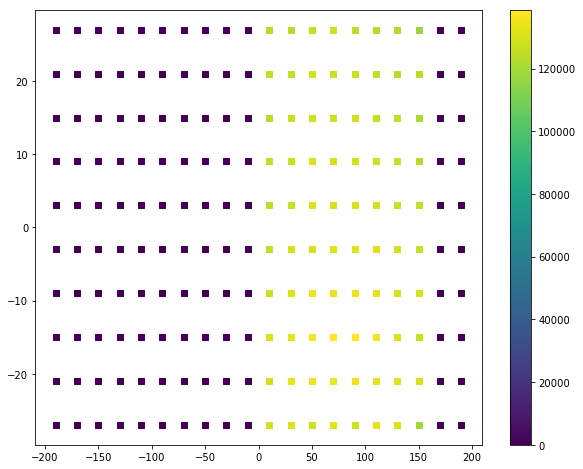

In [34]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]
data = data[fitf.in_range(data.X,      0,   150)]
data = data[fitf.in_range(data.Y,    -30,    30)]
data = data[fitf.in_range(data.Z,    150,   200)]

E = data.S2e.values * zcorr(data.Z.values)[0]
pf, _, cb = profile_and_scatter(data.X.values, data.Y.values, E, (20, 10), xrange=(-200, 200), yrange=(-30, 30))

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return (eref/ e, 0)
    return xycorr
xycorr = get_xycorr(*pf[:-1])

F0: [  2.93007191e+06   5.46985596e+03   1.23130305e+03]
F1: [  2.38531493e+06   7.44670194e+03   8.60695828e+02]
F2: [  2.61043005e+07   1.30815429e+05   5.25661955e+03]


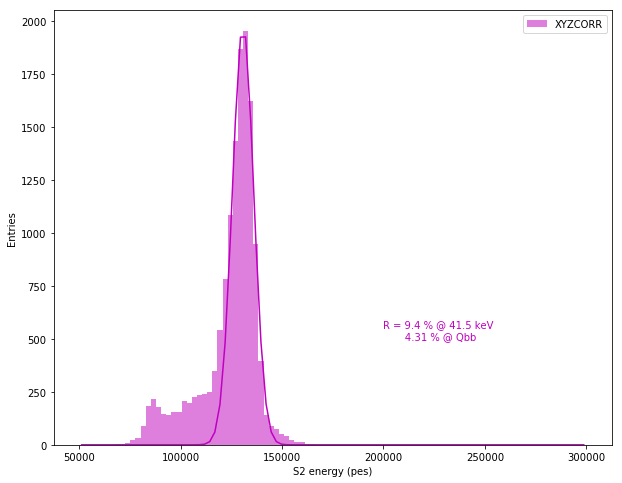

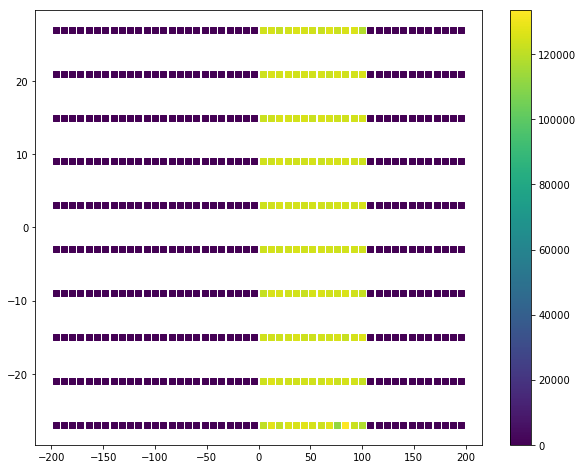

In [35]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]
data = data[fitf.in_range(data.Y,    -30,    30)]
data = data[fitf.in_range(data.Z,    150,   200)]
data = data[fitf.in_range(data.X,      0,   100)]

bins = np.linspace(50e3, 30e4, 100)
E = np.array(data.S2e.values)
plt.figure()
#y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(data.Z.values)[0]
#y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(data.X.values, data.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="m"); x2 = x2[:-1] + np.diff(x2) * 0.5


m0, m1, m2 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)]
#f0 = fitf.fit(fitf.gauss, x0, y0, (1e8, m0, 3000), fit_range=(m0 - 20000, m0 + 20000))
#f1 = fitf.fit(fitf.gauss, x1, y1, (1e8, m1, 3000), fit_range=(m1 - 20000, m1 + 20000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e8, m2, 3000), fit_range=(m2 - 10000, m2 + 20000))

#plt.plot(x0, f0.fn(x0), "b-")
#plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x2), "m-")

r0, r1, r2 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1]
#plt.text(200e3, 2000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (511/2458)**0.5), color="b")
#plt.text(200e3, 4000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (511/2458)**0.5), color="g")
#plt.text(200e3, 6000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")
plt.text(200e3, 500, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")
plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)

plt.figure()
pf, _, cb = profile_and_scatter(data.X.values, data.Y.values, E, (50, 10), xrange=(-200, 200), yrange=(-30, 30))

130312.026803


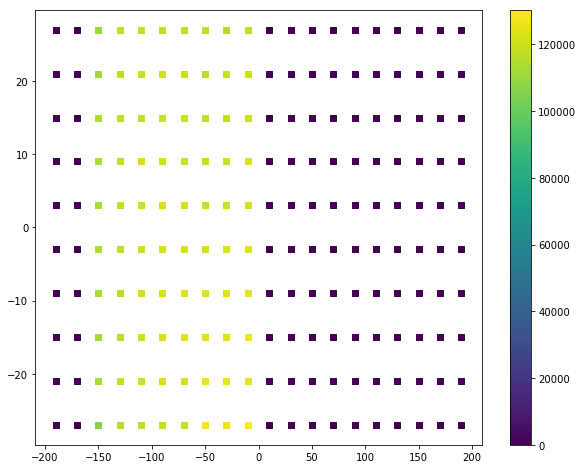

In [43]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]
data = data[fitf.in_range(data.X,   -150,     0)]
data = data[fitf.in_range(data.Y,    -30,    30)]
data = data[fitf.in_range(data.Z,    150,   200)]

E = data.S2e.values * zcorr(data.Z.values)[0]
pf, _, cb = profile_and_scatter(data.X.values, data.Y.values, E, (20, 10), xrange=(-200, 200), yrange=(-30, 30))

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = np.max(es)
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return (eref/ e, 0)
    return xycorr
xycorr = get_xycorr(*pf[:-1])

F0: [  2.93007191e+06   5.46985596e+03   1.23130305e+03]
F1: [  2.38531493e+06   7.44670194e+03   8.60695828e+02]
F2: [  3.49612548e+07   1.33693621e+05   4.45441668e+03]


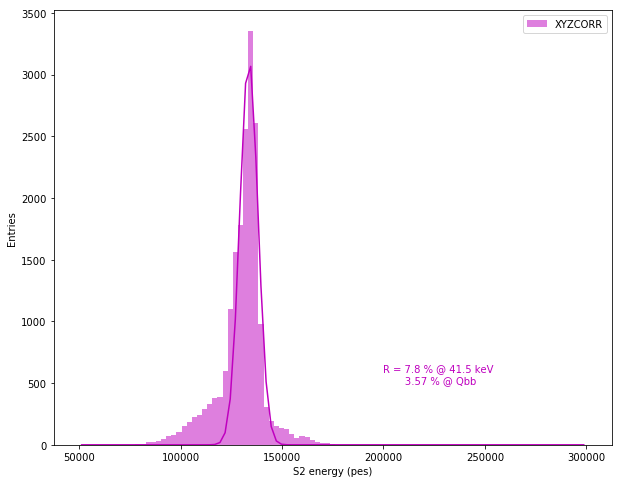

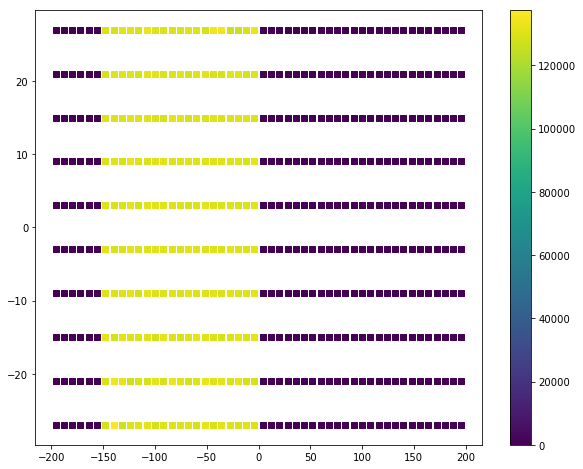

In [49]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]
data = data[fitf.in_range(data.Y,    -30,    30)]
data = data[fitf.in_range(data.Z,    150,   200)]
data = data[fitf.in_range(data.X,   -150,     0)]

bins = np.linspace(50e3, 30e4, 100)
E = np.array(data.S2e.values)
plt.figure()
#y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(data.Z.values)[0]
#y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(data.X.values, data.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="m"); x2 = x2[:-1] + np.diff(x2) * 0.5


m0, m1, m2 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)]
#f0 = fitf.fit(fitf.gauss, x0, y0, (1e8, m0, 3000), fit_range=(m0 - 20000, m0 + 20000))
#f1 = fitf.fit(fitf.gauss, x1, y1, (1e8, m1, 3000), fit_range=(m1 - 20000, m1 + 20000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e8, m2, 3000), fit_range=(m2 - 10000, m2 + 10000))

#plt.plot(x0, f0.fn(x0), "b-")
#plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x2), "m-")

r0, r1, r2 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1]
#plt.text(200e3, 2000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (511/2458)**0.5), color="b")
#plt.text(200e3, 4000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (511/2458)**0.5), color="g")
#plt.text(200e3, 6000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")
plt.text(200e3, 500, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")
plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)

plt.figure()
pf, _, cb = profile_and_scatter(data.X.values, data.Y.values, E, (50, 10), xrange=(-200, 200), yrange=(-30, 30))